In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.read_open_dataset import DatasetOpenDataset
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from source.utils import accuracy_per_class
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20 or OpenDataset
EXP_NAME = 'HR_NORM_'
FEATURE_SIZE = 32
UMAP_NEIGHTBORS = 15
N_EPOCHS = 4000
RESULTS_PATH = 'results'
MODEL_NAME = 'UMAP'

In [3]:
if datasetName == 'PAMAP2':
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3']
    signals=['heartrate']
    dataset = DatasetPAMAP2(seconds = 4 , mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')
    
elif datasetName == 'OpenDataset':
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'heart_rate ']
    signals = ['heart_rate']
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    dataset = DatasetOpenDataset(mode = 'leave-one-subject')
    

    
CLASS_LABELS = dataset.activities
save_name = datasetName + '_' + EXP_NAME
saver = MetricsSaver(save_name, rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [4]:
# dataset.loadData(cache = False)
# dataset.filterSignals(signals)

In [5]:
# mean_hr = np.mean(dataset.X_train.squeeze(), axis=1)
# individuals = np.unique(dataset.I_train)

# for indv in individuals:
#     idx = dataset.I_train == indv
#     ind_mean = np.mean(mean_hr[idx])
#     ind_min = np.min(mean_hr[idx])
#     ind_max = np.max(mean_hr[idx])
#     print('Indv: {} - N windows: {} - Mean: {} - Min: {} - Max: {}'.format(indv, len(mean_hr[idx]), ind_mean, ind_min, ind_max))
#     acts = np.unique(dataset.y_train[idx])
#     print('Activities Ids: {}'.format(' '.join([str(act) for act in acts])))
#     acts = np.unique(dataset.y_train[idx])
#     print('Activities Names: {}'.format(' '.join([dataset.activities_map[act] for act in acts])))
#     print('')

In [6]:
n_ind = 0
all_res_df = None
predicted_classes = []
real_classes = []
while dataset.loadData(cache=True):
    dataset.filterSignals(signals)
    
    # Normalization stuff
    
    
    # mean_hr = np.mean(dataset.X_train.squeeze(), axis=1)
    # for indv in np.unique(dataset.I_train):
    #     idx = dataset.I_train == indv
    #     # ind_mean = np.mean(mean_hr[idx])
    #     ind_min, ind_max = dataset.hr_limits[indv]
    #     # ind_min = np.min(mean_hr[idx])
    #     # ind_max = np.max(mean_hr[idx])
    #     # print('Indv: {} - N windows: {} - Mean: {} - Min: {} - Max: {}'.format(indv, len(mean_hr[idx]), ind_mean, ind_min, ind_max))
    #     # acts = np.unique(dataset.y_train[idx])
    #     # print('Activities Ids: {}'.format(' '.join([str(act) for act in acts])))
    #     # acts = np.unique(dataset.y_train[idx])
    #     # print('Activities Names: {}'.format(' '.join([dataset.activities_map[act] for act in acts])))
    #     # print('')
    #     # ind_min, ind_max
    #     hr_serie = dataset.X_train[idx].squeeze()
    #     hr_serie = hr_serie - ind_min / (ind_max - ind_min)
    #     dataset.X_train[idx] = np.expand_dims(hr_serie, axis = 2)
    
    
    # mean_hr = np.mean(dataset.X_test.squeeze(), axis=1)
    # for indv in np.unique(dataset.I_test):
    #     idx = dataset.I_test == indv
        
    #     ind_min, ind_max = dataset.hr_limits[indv]
    #     # ind_mean = np.mean(mean_hr[idx])
    #     # ind_min = np.min(mean_hr[idx])
    #     # ind_max = np.max(mean_hr[idx])
    #     # print('Indv: {} - N windows: {} - Mean: {} - Min: {} - Max: {}'.format(indv, len(mean_hr[idx]), ind_mean, ind_min, ind_max))
    #     # acts = np.unique(dataset.y_train[idx])
    #     # print('Activities Ids: {}'.format(' '.join([str(act) for act in acts])))
    #     # acts = np.unique(dataset.y_train[idx])
    #     # print('Activities Names: {}'.format(' '.join([dataset.activities_map[act] for act in acts])))
    #     # print('')
    #     # dataset.X_test[idx] = np.expand_dims(dataset.X_test[idx].squeeze() - ind_min, axis = 2)
    #     hr_serie = dataset.X_test[idx].squeeze()
    #     hr_serie = hr_serie - ind_min / (ind_max - ind_min)
    #     dataset.X_test[idx] = np.expand_dims(hr_serie, axis = 2)
        
        
    # ----------------------------------------------------------
    
    ts_train = TSerie(dataset.X_train, dataset.Int_train, I=dataset.I_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test, I=dataset.I_test)
    
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    
    model = UMAP_FL(n_components=32,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='euclidean')
    ts_train.features = model.fit_transform(ts_train.features)
    ts_test.features = model.transform(ts_test.features)




    # --------------------- Classify per intensity-------------------------


    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    
    # Add them to the global predictions
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)

    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)



    # --------------------- Classify per activities-------------------------
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

    train_bin_y = np.copy(ts_train.y)
    test_bin_y = np.copy(ts_test.y)

    target_intensity = 0

    train_bin_y[train_bin_y != target_intensity] = -1
    test_bin_y[test_bin_y != target_intensity] = -1
    train_bin_y[train_bin_y == target_intensity] = 1
    test_bin_y[test_bin_y == target_intensity] = 1
    train_bin_y[train_bin_y ==-1] = 0
    test_bin_y[test_bin_y ==-1] = 0


    if len(np.unique(dataset.y_test)) !=len(np.unique(dataset.y_train)):
        continue
    
    n_ind = n_ind + 1
    res_df = accuracy_per_class(
        clf, 
        train_bin_y, test_bin_y, 
        ts_train.features, ts_test.features, 
        dataset.y_train, dataset.y_test, 
        dataset.activities_map,
        is_binary=True,
    )
    
    if all_res_df is None:
        all_res_df = res_df
    else:
        all_res_df.loc[:, all_res_df.columns != 'classes'] = all_res_df.loc[:, all_res_df.columns != 'classes'] + res_df.loc[:, res_df.columns != 'classes']
    
    # break

all_res_df.loc[:, all_res_df.columns != 'classes'] = all_res_df.loc[:, all_res_df.columns != 'classes'] / n_ind

predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

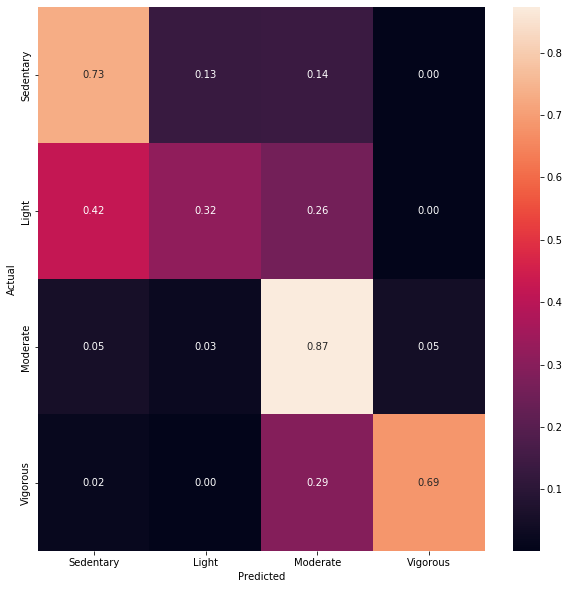

In [7]:
saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_PAI_HR_NORM_{}'.format(MODEL_NAME), labels=dataset.intensities, xrotation=90)

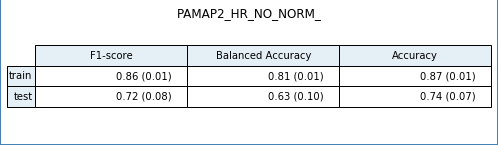

In [8]:
saver.toImage()

In [9]:
all_res_df

,classes,precision,recall,f1_score,accuracy,bal_accuracy
0,lying,1.0,0.765388,0.842193,0.765388,0.765388
1,sitting,1.0,0.676241,0.763519,0.676241,0.676241
2,standing,1.0,0.354577,0.472653,0.354577,0.354577
3,walking,0.0,0.000000,0.000000,0.998428,0.998428
4,running,0.0,0.000000,0.000000,1.000000,1.000000
5,cycling,0.0,0.000000,0.000000,1.000000,1.000000
6,Nordic_walking,0.0,0.000000,0.000000,0.998252,0.998252
7,ascending_stairs,0.0,0.000000,0.000000,0.975262,0.975262
8,descending_stairs,0.0,0.000000,0.000000,0.990000,0.990000
9,vacuum_cleaning,0.0,0.000000,0.000000,0.918832,0.918832
